In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *

In [4]:
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'GeForce GTX 1050 Ti'

### Data

In [5]:
path = Path('path_2')

In [6]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",
        ds_tfms=get_transforms(), size=(256,256), bs=150, num_workers=4).normalize()

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'pneumonia'], 3, 600, 150)

In [8]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 600
Number of examples in validation: 150


In [9]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([150, 3, 256, 256]), torch.Size([150]))

---

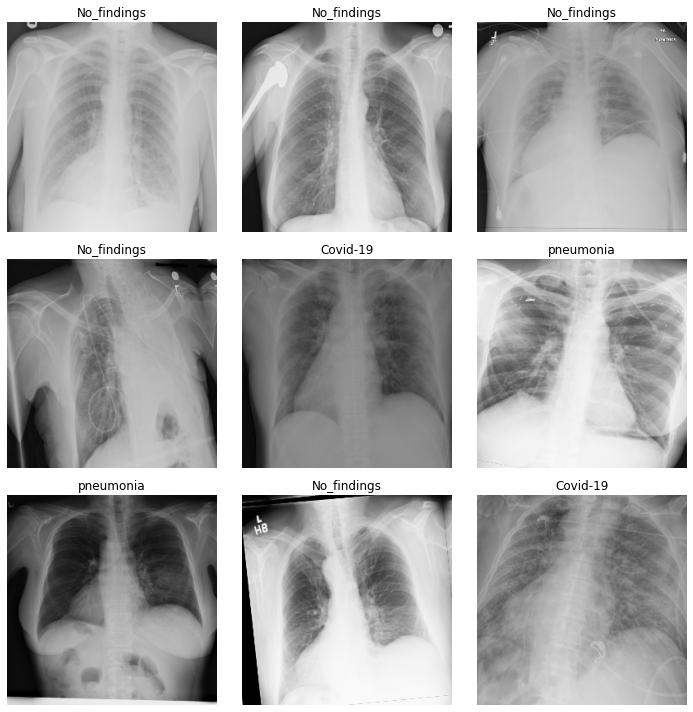

In [10]:
data.show_batch(rows=3, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [11]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [12]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [13]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [14]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    maxpooling(),
    conv_block(256, 512, size = 1),
    conv_block(512, 256, size = 1),
    conv_block(256, 128, size = 1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(363, 3)
)

# model = nn.Sequential(
#     conv_block(3, 8),
#     maxpooling(),
#     conv_block(8, 16),
#     maxpooling(),
#     triple_conv(16, 32),
#     maxpooling(),
#     triple_conv(32, 64),
#     maxpooling(),
#     triple_conv(64, 128),
#     maxpooling(),
#     triple_conv(128, 256),
#     conv_block(256, 128, size=1),
#     conv_block(128, 256),
#     conv_layer(256, 3),
#     Flatten(),
#     nn.Linear(507, 3)
# )


In [15]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)


In [16]:
test = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [17]:
print(test.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [18]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [19]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 

In [70]:
learn.fit_one_cycle(40, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.891063,1.073195,0.666667,00:45
1,0.792111,1.068237,0.166667,00:37
2,0.735537,1.067542,0.166667,00:43
3,0.667522,1.100813,0.166667,00:43
4,0.624843,1.191110,0.166667,00:50
5,0.601636,1.136657,0.166667,00:49
6,0.580115,0.975860,0.666667,00:50
7,0.552589,1.170420,0.666667,00:49
8,0.533755,1.100025,0.713333,00:51
9,0.518533,0.984766,0.746667,00:52


In [73]:
learn.save('saved_inference', with_opt=True)

In [81]:
test = test.load('saved_inference', with_opt=True)

In [50]:
#learn.export(os.path.abspath('./trained_model.pkl'))

In [46]:
#test = load_learner(os.path.abspath('./'), 'trained_model.pkl')
#test = load_learner(os.path.abspath('./'), test = ImageList.from_folder('test'))
test = load_learner(os.path.abspath('./'))

In [28]:
test.load(os.path.abspath('./my_export2.pth'))

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: D:\covid detector\COVID-19-master\covid-detector;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: D:\covid detector\COVID-19-master\covid-detector;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Sequential(
      

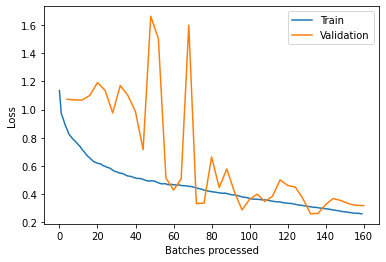

In [82]:
learn.recorder.plot_losses()

In [83]:
test.recorder.plot_losses()

AttributeError: 'Learner' object has no attribute 'recorder'

In [79]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 150


In [85]:
covid_images = ImageList.from_folder('test')

In [86]:
img = data.valid_ds[2][0]

In [88]:
test.predict(covid_images[0])

(Category tensor(0), tensor(0), tensor([0.7533, 0.2390, 0.0076]))

In [84]:
x,y = test.get_preds(ds_type=DatasetType.Test)

AttributeError: 'NoneType' object has no attribute 'dataset'

In [ ]:
accuracy(x,y)

In [20]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [21]:
accuracy(probs,targets)

tensor(0.8667)

In [22]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'pneumonia'], 3, 600, 150)

In [23]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

150 130 0.8666666666666667
[[17  2  6]
 [ 0 98  2]
 [ 0 10 15]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.68      0.81        25
 No_findings       0.89      0.98      0.93       100
   Pneumonia       0.65      0.60      0.63        25

    accuracy                           0.87       150
   macro avg       0.85      0.75      0.79       150
weighted avg       0.87      0.87      0.86       150



In [24]:
interp = ClassificationInterpretation.from_learner(learn)

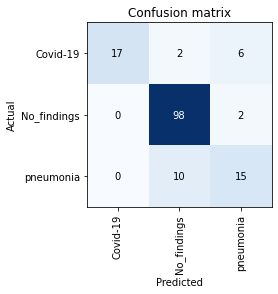

In [25]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);